# Algoritmos Genéticos - Utilización de librerias específicas (DEAP)

*Optimización del problema del agente viajero (TSP)*

**CONTEXTO:**

El problema del agente viajero (TSP – Travelling Salesman Problem) es un problema de optimización combinatorios con variables discretas. Consiste en encontrar el tour óptimo para un vendedor que visita un conjunto de ciudades, partiendo de una ciudad y finalizando en la misma (igualmente complicado si no se acaba en la misma ciudad), recorriendo la distancia mínima y sin visitar ninguna ciudad más de una vez (problema de minimización). El problema se cita de variables discretas, porque el conjunto de ciudades es un conjunto discreto.

Aunque el enunciado es sencillo, al día de hoy no existe un algoritmo determinista que resuelva el problema de manera óptima para cualquier número de ciudades, en un tiempo razonable.
Resulta obvio, que la complejidad del problema se incrementa con el número de ciudades. Considerando que no importa la ciudad de origen entre todas las ciudades y que la distancia entre ciudades es simétrica, el número de posibles soluciones al problema está dado por: (N-1)!/2


Tomando el caso de 10 ciudades, el número de soluciones posibles es **181.440**, si evaluar cada solución toma 1 segundo, el tiempo requerido para verificar el universo de posibilidades sería de 50,4 horas. Si adoptamos 20 ciudades, el tiempo se eleva a casi dos mil millones de años. Resulta evidente, que abordar un problema de este tipo mediante fuerza bruta, es inviable. Problemas similares, son denominados “problemas intratables” debido a su complejidad. Cabe resaltar, que, para un número bajo de ciudades, existen algoritmos deterministas y eficientes que consigue resolver el problema de manera óptima.

Desde el punto de vista del ámbito de la ingeniería, TSP tiene aplicaciones en:
* Problemas de transporte
* Logística
* Planificación de rutas de vehículos autónomos
* entre otros.


**ALCANCE Notebook:**

Se presenta un esquema básico para implementar este caso de uso de los Algoritmos Genéticos. La librería se denomina DEAP (*Distributed Evolutionary Algorithms in Python*).

Documentación y demás en: https://deap.readthedocs.io/en/master/


## Instalaciones y Dependencias Necesarias

In [1]:
pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 4.5 MB/s 


In [2]:
import random
import json
import numpy
import matplotlib.pyplot as plt


# Importaciones para AG
from deap import algorithms #incluye implementaciones completas de algoritmos genéticos, eaSimple por ejemplo. Se muestra un ejemplo en dónde hacemos a mano algo equivalente.
from deap import base #incluye las clases base de deap. En concreto dos son importantes en nuestro ejemplo, base.Fitness y base.Toolbox.
from deap import creator #permite crear clases nuevas.
from deap import tools #herramientas para implementar los algoritmos genéticos: operadores genéticos (selección, cruce y mutación), hallofFame, estadística, registro de evolución, etc.

## Obtención de datos

Se adjuntan algunos archivos “*.json*”, que contienen las siguientes claves como parte de un diccionario de valores:

*	*TourSize*: Representa el número de ciudades del problema
*	*OptTour*: Solución óptima al problema
*	*OptDistance*: Distancia óptima que recorre el viajero para el tour óptimo
*	*DistanceMatrix*: Matriz de distancias entre ciudades


In [3]:
# Archivos pueden arrastrarse al área de trabajo o procesarse en local

# Version Online
!wget https://github.com/AxelSkrauba/Taller_IA/raw/main/4_AG_Optimization/data_TSP.zip

--2022-08-24 13:55:11--  https://github.com/AxelSkrauba/Taller_IA/raw/main/4_AG_Optimization/data_TSP.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AxelSkrauba/Taller_IA/main/4_AG_Optimization/data_TSP.zip [following]
--2022-08-24 13:55:11--  https://raw.githubusercontent.com/AxelSkrauba/Taller_IA/main/4_AG_Optimization/data_TSP.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27992 (27K) [application/zip]
Saving to: ‘data_TSP.zip’

data_TSP.zip        100%[===================>]  27.34K  --.-KB/s    in 0.002s  

2022-08-24 13:55:12 (11.9 MB/s) - ‘data_TSP.zip’ saved [27992/27992]



In [4]:
!unzip data_TSP.zip

# Se obtienen 3 archivos si todo va bien, abajo se listan.

Archive:  data_TSP.zip
  inflating: gr17.json               
  inflating: gr24.json               
  inflating: gr120.json              


In [32]:
# gr*.json contiene el mapa de distancias entre ciudades en formato JSON
# La versión más simple disponible es gr17.json, es decir, para 17 ciudades.

# Se puede probar la implementación para cualquiera
# Los tiempos cambian, algunos parámetros deberán optimizarse pero va
with open("gr17.json", "r") as tsp_data:
    tsp = json.load(tsp_data)

# Matriz de distancia
distance_map = tsp["DistanceMatrix"]
# Número de ciudades que visitar 
IND_SIZE = tsp["TourSize"]

# Solución óptima para comparar con la hallada:
distancia_optima =  tsp["OptDistance"]
ruta_optima =  tsp["OptTour"]   # Es circular, el orden es lo importante


## Función para obtener el Fitness

In [11]:
def evalTSP(individual):
    """ Función objetivo, calcula la distancia que recorre el viajante"""
    # distancia entre el último elemento y el primero
    distance = distance_map[individual[-1]][individual[0]]
    # distancia entre el resto de ciudades
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += distance_map[gene1][gene2]
    return distance,

## Instancias de la librería

In [ ]:
# Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Los pesos definen si se Maximiza (1) o Minimiza (-1) en la Optimización
# En este problema... nos interesa minimizar la distancia recorrida.

creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# Generación de un tour aleatorio
toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)

# Generación de inviduos y población
toolbox.register("individual", tools.initIterate, creator.Individual, 
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual, 100)   # Acá está la cantidad de individuos (100)

# registro de operaciones genéticas
toolbox.register("mate", tools.cxOrdered)   # Operador de cruce ordenado, permite intercambiar información genéticas
                                            # de dos invividuos sin que se repitan los genes.
                                            # Para este problema no se puede utilizar cualquier tipo de operador de cruce,
                                            # ya que podrían darse soluciones no válidas.
                                            # Siempre se pueden penalizar individuos no válidos, pero es preferible utilizar
                                            # operadores que aseguren individuos válidos.
                                            # Existen otros, ej.: cxPartialyMatched
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Mutación de mezcla de índices
toolbox.register("select", tools.selTournament, tournsize=3)     # Selecion
toolbox.register("evaluate", evalTSP)       # Evaluación, acá se vincula a nuestra función de optimizar

## Evaluación

In [13]:
random.seed(100)    # Para garantizar repetibilidad simplemente

CXPB = 0.7 # Probabilidad de crossover
MUTPB = 0.3 # Probabilidad de mutación
NGEN = 120 # Cantidad de generaciones


pop = toolbox.population() 
MU, LAMBDA = len(pop), len(pop) # Parámetros para implementación eaMuPlusLambda

hof = tools.HallOfFame(1) # Espacio para guardar los mejores individuos, se guarda el mejor en este caso (1)

# Estadisticas a almacenar de las generaciones
stats = tools.Statistics(lambda ind: ind.fitness.values) 
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)
logbook = tools.Logbook()     # Para almacenar todas las estadísticas calculadas por generación en un solo objeto.

Ejecutar 1 algoritmo por vez, y los resultados. Sino se verá el último solamente.

### eaSimple 

Implementación ya vista, evaluar desempeño respecto a `eaMuPlusLambda`.

In [29]:
implementacion = "eaSimple"
pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB,
                                   NGEN, stats=stats, halloffame=hof, 
                                   verbose=True)

gen	nevals	avg 	std	min 	max 
0  	0     	2136	0  	2136	2136
1  	79    	2281.43	343.725	2136	3620
2  	75    	2182.67	163.751	2136	3088
3  	81    	2252.82	307.242	2136	3399
4  	84    	2274.66	368.355	2136	3892
5  	77    	2297.82	386.521	2136	3715
6  	88    	2325.39	385.28 	2136	3701
7  	76    	2338.13	473.175	2136	4167
8  	76    	2320.37	397.704	2136	3778
9  	80    	2234.53	302.446	2136	3869
10 	82    	2322.53	418.155	2136	3877
11 	74    	2265.49	345.771	2136	3749
12 	78    	2201.99	224.797	2136	3535
13 	77    	2263.64	332.519	2136	3701
14 	86    	2320.95	440.411	2136	4385
15 	69    	2276.03	309.483	2136	3399
16 	72    	2268.19	383.813	2136	4465
17 	83    	2223.35	256.852	2136	3760
18 	84    	2307.44	449.698	2136	4696
19 	79    	2267.34	340.92 	2136	3867
20 	78    	2348.35	471.549	2136	4290
21 	61    	2283.15	374.333	2136	4046
22 	89    	2240.71	310.054	2136	3612
23 	79    	2234.63	292.498	2136	3535
24 	79    	2291.65	460.802	2136	4860
25 	71    	2297.16	381.875	2136	4213
26 	72    	2336

### eaMuPlusLambda

Se utiliza la implementación denominada *mupluslambda*.
Este algoritmo es más elitista y también requiere un mayor tiempo de computación. Sin embargo, arroja mejores resultados en una gran variedad de escenarios.

El algoritmo se basa en que cada nueva generación se extrae a partir de la llamada *población extendida*, que no es más que la combinación de la población actual (de tamaño "*mu*") y la descendencia (de tamaño "*lambda*"). Resulta más elitista, porque los hijos deben competir con los padres para pasar finalmente a la siguiente generación.

Existen otras variaciones como: `eaMuCommaLambda`.

In [27]:
implementacion = "eaMuPlusLambda"
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, 
                                            LAMBDA, CXPB, MUTPB, 
                                            NGEN, stats=stats, 
                                            halloffame=hof)

gen	nevals	avg    	std    	min 	max 
0  	0     	2290.44	446.486	2136	4418
1  	100   	2144.91	47.5033	2136	2517
2  	100   	2141.34	40.7085	2136	2517
3  	100   	2136   	0      	2136	2136
4  	100   	2136   	0      	2136	2136
5  	100   	2136   	0      	2136	2136
6  	100   	2136   	0      	2136	2136
7  	100   	2136   	0      	2136	2136
8  	100   	2136   	0      	2136	2136
9  	100   	2136   	0      	2136	2136
10 	100   	2136   	0      	2136	2136
11 	100   	2136   	0      	2136	2136
12 	100   	2136   	0      	2136	2136
13 	100   	2136   	0      	2136	2136
14 	100   	2136   	0      	2136	2136
15 	100   	2136   	0      	2136	2136
16 	100   	2136   	0      	2136	2136
17 	100   	2136   	0      	2136	2136
18 	100   	2136   	0      	2136	2136
19 	100   	2136   	0      	2136	2136
20 	100   	2136   	0      	2136	2136
21 	100   	2136   	0      	2136	2136
22 	100   	2136   	0      	2136	2136
23 	100   	2136   	0      	2136	2136
24 	100   	2136   	0      	2136	2136
25 	100   	2136   	0      	2136	2136
2

## Resultados

In [25]:
# Función para graficar las variables almacenadas
def plot_evolucion(log, title):
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.fill_between(gen, fit_mins, fit_maxs, 
                     where=fit_maxs >= fit_mins, 
                     facecolor="g", alpha=0.2)
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("Fitness")
    ax1.legend(["Min", "Max", "Avg"])
    plt.grid(True)
    plt.title(title)
    plt.show()

Mejor fitness:  (2136.0,)
Mejor individuo:  [6, 12, 3, 8, 11, 15, 0, 16, 5, 2, 10, 4, 1, 9, 14, 13, 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  


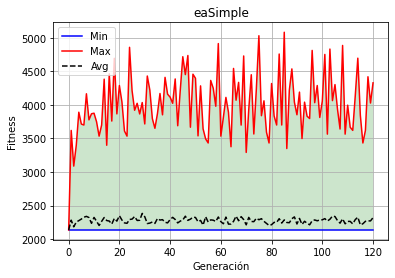

In [30]:
print("Mejor fitness: ", pop[0].fitness.values)
print("Mejor individuo: ", pop[0])
plot_evolucion(logbook, implementacion) 

In [31]:
# Comparación con lo óptimo
print("Distancia Óptima: ", distancia_optima)
print("Ruta Óptima: ", ruta_optima) # Es circular, el orden es lo importante

Distancia Óptima:  2085
Ruta Óptima:  [15, 11, 8, 4, 1, 9, 10, 2, 14, 13, 16, 5, 7, 6, 12, 3, 0]


## Extras

Se adjunta un cuadro comparativos de resultados, realizado por estudiantes de Inteligencia Computacioanl.
Pueden apreciarse diferentes configuraciones para estos problemas y los desempeños.

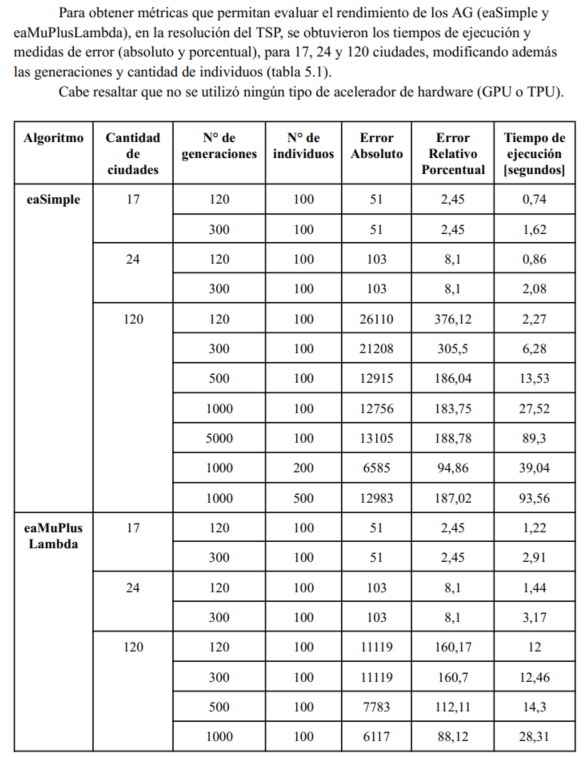